In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn import metrics
from statsmodels.tools.eval_measures import rmse
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import joblib

In [7]:
# Importando os dados
df = pd.read_excel("brent_oil_prices.xlsx")

# Renomeando as colunas
df.rename(columns={'Data': 'ds', 'Preço - petróleo bruto - Brent (FOB)': 'y'}, inplace = True)

In [8]:
# Verificando metadados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      9517 non-null   datetime64[ns]
 1   y       9517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 148.8 KB


In [9]:
# Verificando se há algum valor nulo
df.isnull().sum()

,0
ds,0
y,0


In [10]:
df.sort_index(ascending=False, inplace=True)
df

,ds,y
9516,2024-11-18,74.35
9515,2024-11-15,73.45
9514,2024-11-14,73.39
9513,2024-11-13,72.86
9512,2024-11-12,72.56
...,...,...
4,1987-05-26,18.63
3,1987-05-25,18.60
2,1987-05-22,18.55
1,1987-05-21,18.45


In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
train = df.iloc[:-365]
test = df.iloc[-365:]

## Modelo 1 - baseline

In [13]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/0h3eluuf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/6skgi6_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78672', 'data', 'file=/tmp/tmp0u67sdr5/0h3eluuf.json', 'init=/tmp/tmp0u67sdr5/6skgi6_e.json', 'output', 'file=/tmp/tmp0u67sdr5/prophet_modelpdzi_sao/prophet_model-20241203101709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11524,2025-04-29,96.485832,81.132224,110.663217
11525,2025-04-30,96.468339,81.730338,111.010775
11526,2025-05-01,96.597292,81.208420,110.776284
11527,2025-05-02,96.651501,81.369325,111.778354
11528,2025-05-03,97.141666,82.567182,112.544954


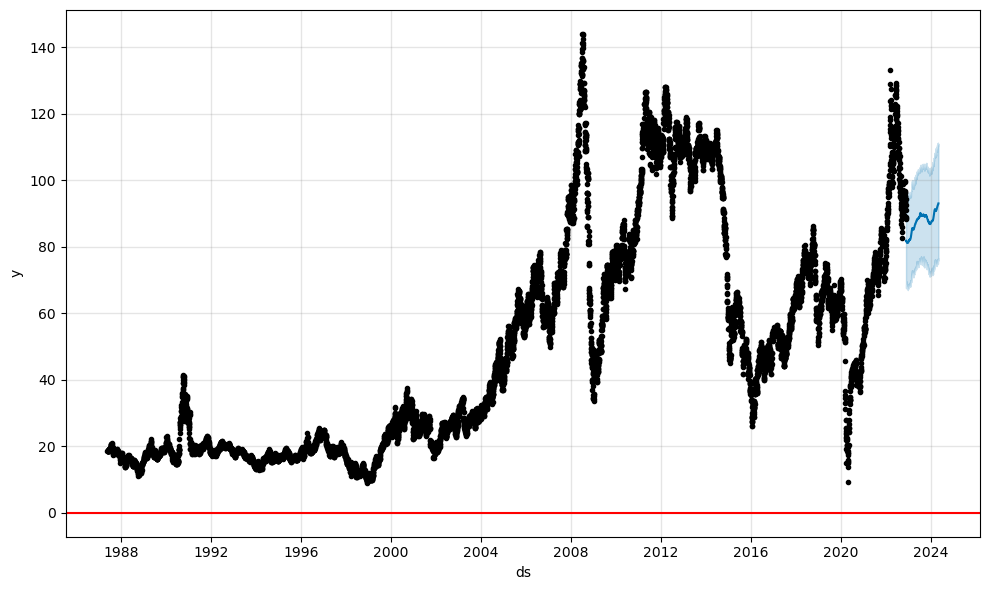

In [ ]:
# Plotando
m.plot(forecast)
plt.axhline(y=0, color='red')

In [14]:
plot_plotly(m, forecast)

In [15]:
plot_components_plotly(m, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



## Avaliando o modelo

In [16]:
# Pegando apenas os ultimos 365 dias
predictions = forecast.iloc[-365:]['yhat']

In [17]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictions, test['y']))
print("Mean Value os Test Dataset: ", test['y'].mean())

Root Mean Squared Error entre atuais and valores previstos:  76.21662735948324
Mean Value os Test Dataset:  16.629205479452054


## Modelo 2

In [18]:
# Criando feriados/periodos especificos
feriados = pd.DataFrame([
    # Eventos históricos relevantes
    {'holiday': 'guerra_golfo', 'ds': '1990-07-15', 'lower_window': 0, 'ds_upper': '1991-01-31'},
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2015-01-01'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

    # Eventos geopolíticos e econômicos recentes
    {'holiday': 'corte_producao_opec', 'ds': '2023-04-03', 'lower_window': 0, 'ds_upper': '2023-06-30'},
    {'holiday': 'guerra_russia_ucrania', 'ds': '2023-07-01', 'lower_window': 0, 'ds_upper': '2023-12-31'},
    {'holiday': 'conflito_oriente_medio', 'ds': '2024-01-01', 'lower_window': 0, 'ds_upper': '2024-03-31'},

    # Novos fatores externos relevantes
    {'holiday': 'pandemia_covid-19', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'choque_precos_gas', 'ds': '2021-10-01', 'lower_window': 0, 'ds_upper': '2022-03-01'},
    {'holiday': 'colapso_banco_silicon', 'ds': '2023-03-10', 'lower_window': 0, 'ds_upper': '2023-03-30'},
    {'holiday': 'redução_estoques_petroleo', 'ds': '2024-05-01', 'lower_window': 0, 'ds_upper': '2024-06-30'},
    {'holiday': 'sanções_russia', 'ds': '2024-06-01', 'lower_window': 0, 'ds_upper': '2024-12-31'}
])

for t_col in ['ds', 'ds_upper']:
    feriados[t_col] = pd.to_datetime(feriados[t_col])
feriados['upper_window'] = (feriados['ds_upper'] - feriados['ds']).dt.days
feriados

,holiday,ds,lower_window,ds_upper,upper_window
0,guerra_golfo,1990-07-15,0,1991-01-31,200
1,crise_2008,2008-07-07,0,2008-12-31,177
2,crise_2014,2014-06-01,0,2015-01-01,214
3,crise_2020,2020-02-01,0,2021-03-01,394
4,crise_2022,2022-01-01,0,2022-12-31,364
5,corte_producao_opec,2023-04-03,0,2023-06-30,88
6,guerra_russia_ucrania,2023-07-01,0,2023-12-31,183
7,conflito_oriente_medio,2024-01-01,0,2024-03-31,90
8,pandemia_covid-19,2020-03-01,0,2021-03-01,365
9,choque_precos_gas,2021-10-01,0,2022-03-01,151


In [19]:
m2 = Prophet(holidays=feriados)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/gp8s6h71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/78w0u0eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74245', 'data', 'file=/tmp/tmp0u67sdr5/gp8s6h71.json', 'init=/tmp/tmp0u67sdr5/78w0u0eq.json', 'output', 'file=/tmp/tmp0u67sdr5/prophet_modelclwzcda0/prophet_model-20241203101932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Periodos de crise adicionados')

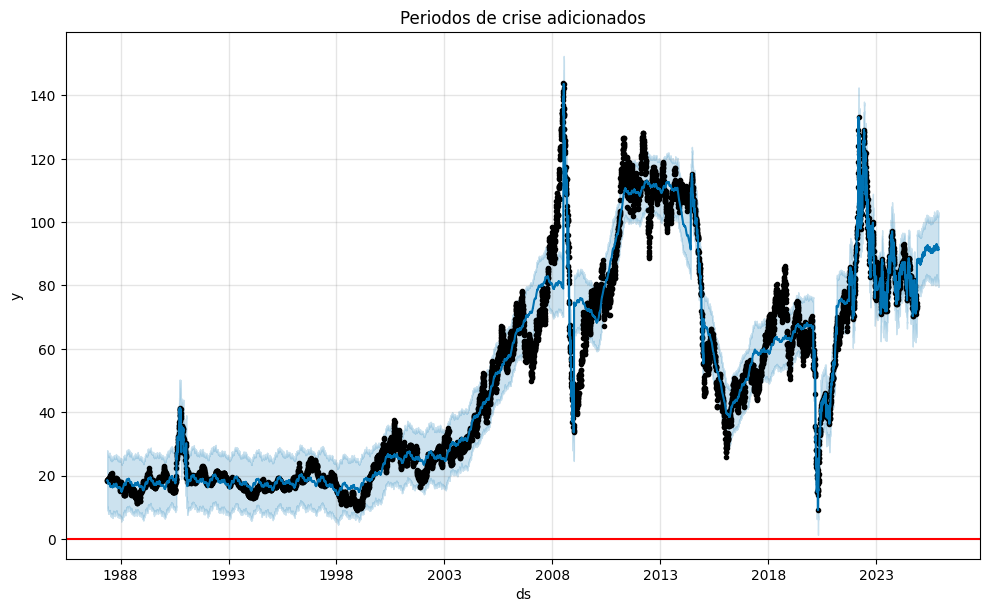

In [20]:
# Plotando
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title("Periodos de crise adicionados")

In [21]:
# Pegando apenas os ultimos 365 dias
predictions2 = forecast2.iloc[-365:]['yhat']

In [22]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictions2, test['y']))
print("Mean Value os Test Dataset: ", test['y'].mean())

Root Mean Squared Error entre atuais and valores previstos:  73.62061546544673
Mean Value os Test Dataset:  16.629205479452054


## Modelo 3

In [25]:
# Criando feriados/periodos especificos
feriados = pd.DataFrame([
    # Eventos históricos relevantes
    {'holiday': 'guerra_golfo', 'ds': '1990-07-15', 'lower_window': 0, 'ds_upper': '1991-01-31'},
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2015-01-01'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

    # Eventos geopolíticos e econômicos recentes
    {'holiday': 'corte_producao_opec', 'ds': '2023-04-03', 'lower_window': 0, 'ds_upper': '2023-06-30'},
    {'holiday': 'guerra_russia_ucrania', 'ds': '2023-07-01', 'lower_window': 0, 'ds_upper': '2023-12-31'},
    {'holiday': 'conflito_oriente_medio', 'ds': '2024-01-01', 'lower_window': 0, 'ds_upper': '2024-03-31'},

    # Novos fatores externos relevantes
    {'holiday': 'pandemia_covid-19', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'choque_precos_gas', 'ds': '2021-10-01', 'lower_window': 0, 'ds_upper': '2022-03-01'},
    {'holiday': 'colapso_banco_silicon', 'ds': '2023-03-10', 'lower_window': 0, 'ds_upper': '2023-03-30'},
    {'holiday': 'redução_estoques_petroleo', 'ds': '2024-05-01', 'lower_window': 0, 'ds_upper': '2024-06-30'},
    {'holiday': 'sanções_russia', 'ds': '2024-06-01', 'lower_window': 0, 'ds_upper': '2024-12-31'}
])

for t_col in ['ds', 'ds_upper']:
    feriados[t_col] = pd.to_datetime(feriados[t_col])
feriados['upper_window'] = (feriados['ds_upper'] - feriados['ds']).dt.days
feriados

,holiday,ds,lower_window,ds_upper,upper_window
0,guerra_golfo,1990-07-15,0,1991-01-31,200
1,crise_2008,2008-07-07,0,2008-12-31,177
2,crise_2014,2014-06-01,0,2015-01-01,214
3,crise_2020,2020-02-01,0,2021-03-01,394
4,crise_2022,2022-01-01,0,2022-12-31,364
5,corte_producao_opec,2023-04-03,0,2023-06-30,88
6,guerra_russia_ucrania,2023-07-01,0,2023-12-31,183
7,conflito_oriente_medio,2024-01-01,0,2024-03-31,90
8,pandemia_covid-19,2020-03-01,0,2021-03-01,365
9,choque_precos_gas,2021-10-01,0,2022-03-01,151


In [26]:
m3 = Prophet(holidays=feriados)
m3.fit(df)
future3 = m3.make_future_dataframe(periods=365)
forecast3 = m3.predict(future3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/_56ptkzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0u67sdr5/1efg22mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83314', 'data', 'file=/tmp/tmp0u67sdr5/_56ptkzv.json', 'init=/tmp/tmp0u67sdr5/1efg22mt.json', 'output', 'file=/tmp/tmp0u67sdr5/prophet_modelsda0n0o3/prophet_model-20241203103046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Periodos de crise adicionados')

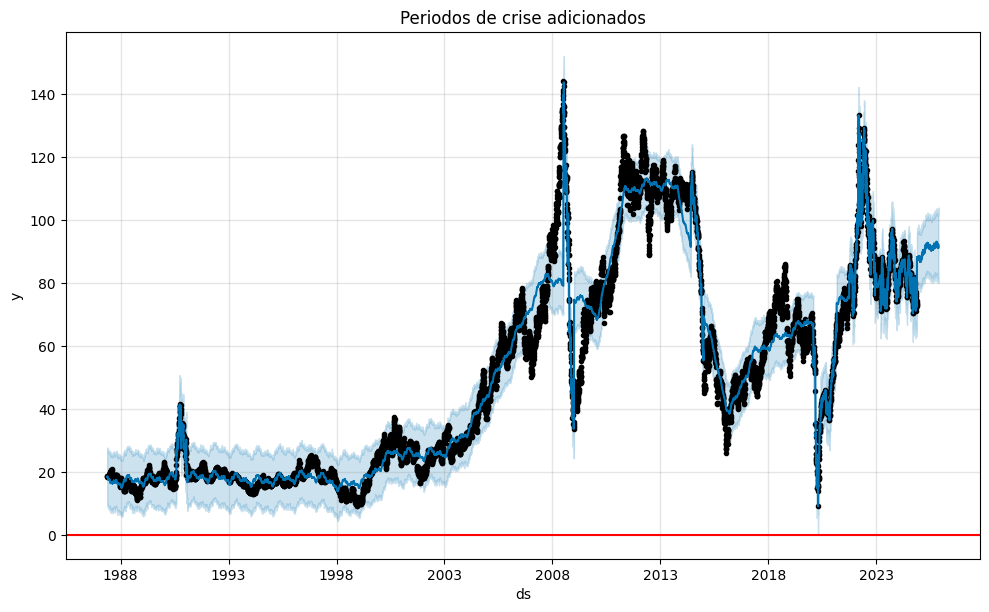

In [27]:
# Plotando
m3.plot(forecast3)
plt.axhline(y=0, color='red')
plt.title("Periodos de crise adicionados")

In [28]:
# Pegando apenas os ultimos 365 dias
predictions3 = forecast3.iloc[-365:]['yhat']

In [29]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictions3, test['y']))
print("Mean Value os Test Dataset: ", test['y'].mean())

Root Mean Squared Error entre atuais and valores previstos:  73.60953218336985
Mean Value os Test Dataset:  16.629205479452054


## Exportando o modelo 3

In [30]:
joblib.dump(m3, 'prophet_model_final.pkl')

['prophet_model_final.pkl']